# Clock view of policy 

In [1]:
import numpy as np
from stable_baselines3 import PPO
import yaml
# 加载模型
model = PPO.load(".././output/best_model/default_12_v0_7680000_steps.zip")
# 加载环境参数
env_id = 'PredatorPrey-v0'
config_id = 'put_back_0'
with open('../params/env_configs.yaml', 'r') as file:
    env_config = yaml.safe_load(file)[env_id][config_id]
visibility_radius = env_config['visibility_radius']
arena_radius = env_config['arena_radius']

In [289]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns

# 使用seaborn设置样式
sns.set(style="whitegrid")

def plot_strategy(r1, theta1, r2, theta2, R, predict_action, visibility_radius=10.0, ax=None):
    """
    绘制单个策略图.

    参数:
        r1 (float): 最近猎物距离.
        theta1 (float): 最近猎物角度(弧度).
        r2 (float): 猎物平均距离.
        theta2 (float): 猎物平均角度(弧度).
        R (float): 离家距离(仅用于决策,不在图中显示).
        predict_action (function): 用于根据输入参数预测动作方向的函数.
        visibility_radius (float, optional): 视野半径.默认值为10.0.
        ax (matplotlib.axes.Axes, optional): 要绘制的轴.如果未提供,将创建新的图形和轴.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 9), dpi = 300)

    # 绘制视野圆
    visibility_circle = plt.Circle((0, 0), visibility_radius, facecolor='steelblue', alpha=0.35, edgecolor='purple')
    ax.add_artist(visibility_circle)
    ax.plot(0, 0, marker='o', markersize=1, color='tomato', linestyle='None')

    # 最近猎物位置
    prey1_x = r1 * np.cos(theta1)
    prey1_y = r1 * np.sin(theta1)
    ax.plot(prey1_x, prey1_y, 'o', markersize=4, label='Nearest Prey Position', color='slateblue')

    # 猎物平均位置
    prey2_x = r2 * np.cos(theta2)
    prey2_y = r2 * np.sin(theta2)
    ax.plot(prey2_x, prey2_y, 'o', markersize=4, label='Average Position of Visible Preys', color='chocolate')

    # 圆心到猎物位置的虚线
    ax.plot([0, prey1_x], [0, prey1_y], 'slateblue', linewidth=1)
    ax.plot([0, prey2_x], [0, prey2_y], 'chocolate', linewidth=1)

    # 预测的动作方向
    action_direction = predict_action(r1, theta1, r2, theta2, R)
    head_length = 0.4
    action_length = 10.0 # 动作箭头长度比虚线短
    action_x = action_length * np.cos(action_direction)
    action_y = action_length * np.sin(action_direction)
    ax.plot([0, action_x], [0, action_y], '--', linewidth=1, color='mediumvioletred', label='Action Direction')
    # ax.arrow(0, 0, action_x, action_y, head_width=0.15, head_length=head_length, linewidth=0.8,
    #         fc='darkorchid', ec='darkorchid', label='Action Direction')

    # 设置图像样式
    ax.set_aspect('equal')
    ax.set_xlim(-visibility_radius-0.1, visibility_radius+0.1)
    ax.set_ylim(-visibility_radius-0.1, visibility_radius+0.1)
    ax.axis('off')
    ax.legend(loc = 'lower left')

def plot_multiple_strategies(params_list, predict_action, visibility_radius=10.0):
    """
    绘制多个策略图.

    参数:
        params_list (list of tuples): 包含参数 (r1, theta1, r2, theta2, R) 的元组列表.
        predict_action (function): 用于根据输入参数预测动作方向的函数.
        visibility_radius (float, optional): 视野半径.默认值为10.0.
    """
    num_plots = len(params_list)
    row = -(-num_plots//3)
    fig, axs = plt.subplots(row, 3, figsize=(18, 6*row), dpi = 300)
    axs = axs.flatten()

    for i, params in enumerate(params_list):
        ax = axs[i] if num_plots > 1 else axs
        plot_strategy(*params, predict_action=predict_action, visibility_radius=visibility_radius, ax=ax)
        # ax.set_title(f'Policy {i+1}')

    # plt.tight_layout()
    plt.show()

# 假设的预测动作函数
def model_predict_action(r1, theta1, r2, theta2, R):
    ave_pos = np.array([r2, theta2])
    closest_pos = np.array([r1, theta1])
    obs = {
        "distance_to_home": np.array([R]),
        "average_position_of_visible_preys": ave_pos,
        "closest_prey_position": closest_pos
    }
    action, _ = model.predict(
        obs,
        deterministic=True
    )
    theta = action*np.pi
    # 这里简单返回 theta1 作为动作方向示例
    return theta

# 测试单个策略图
# plot_strategy(5, np.pi/4, 8, np.pi/3, 10, predict_action=model_predict_action)

# 测试多个策略图

# plot_multiple_strategies(params_list, predict_action=model_predict_action)

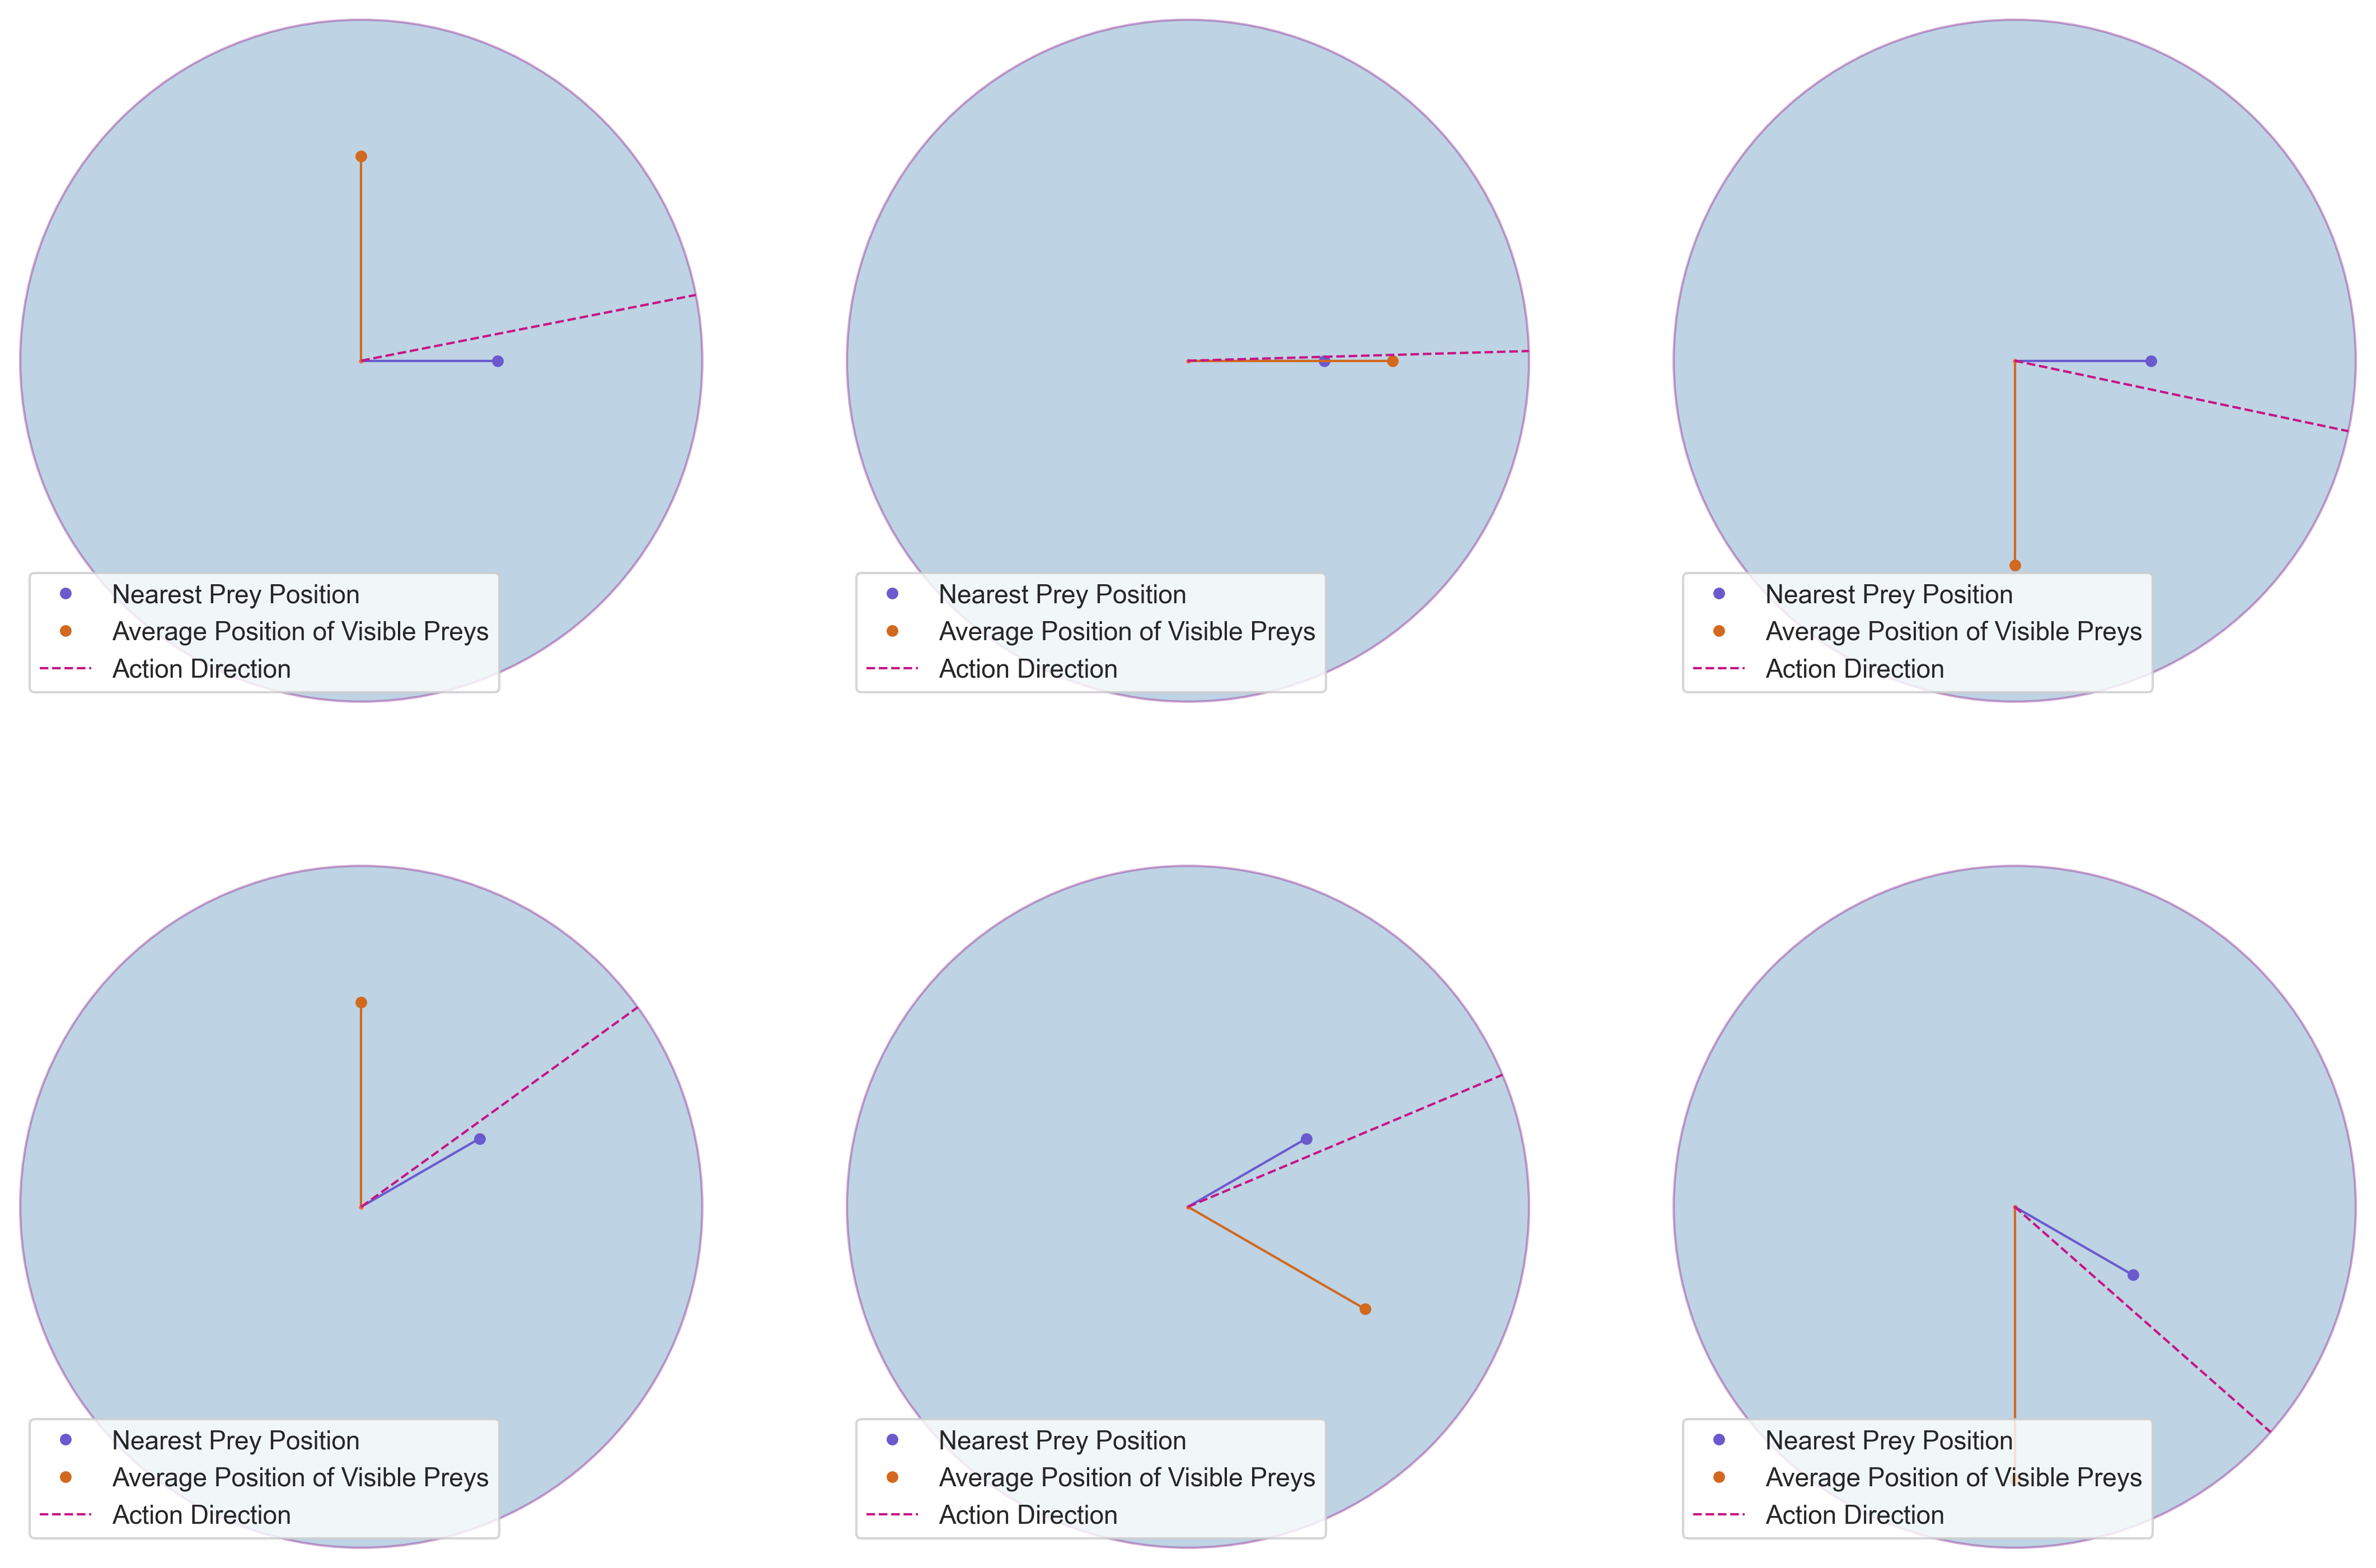

In [536]:
# 测试多个策略图

params_list = [
    (4, 0, 6, np.pi/2, 20),
    (4, 0, 6, 0, 20),
    (4, 0, 6, -np.pi/2, 20),
    (4, np.pi/6, 6, np.pi/2, 20),
    (4, np.pi/6, 6, -np.pi/6, 20),
    (4, -np.pi/6, 8, -np.pi/2, 20)
]
plot_multiple_strategies(params_list, predict_action=model_predict_action)

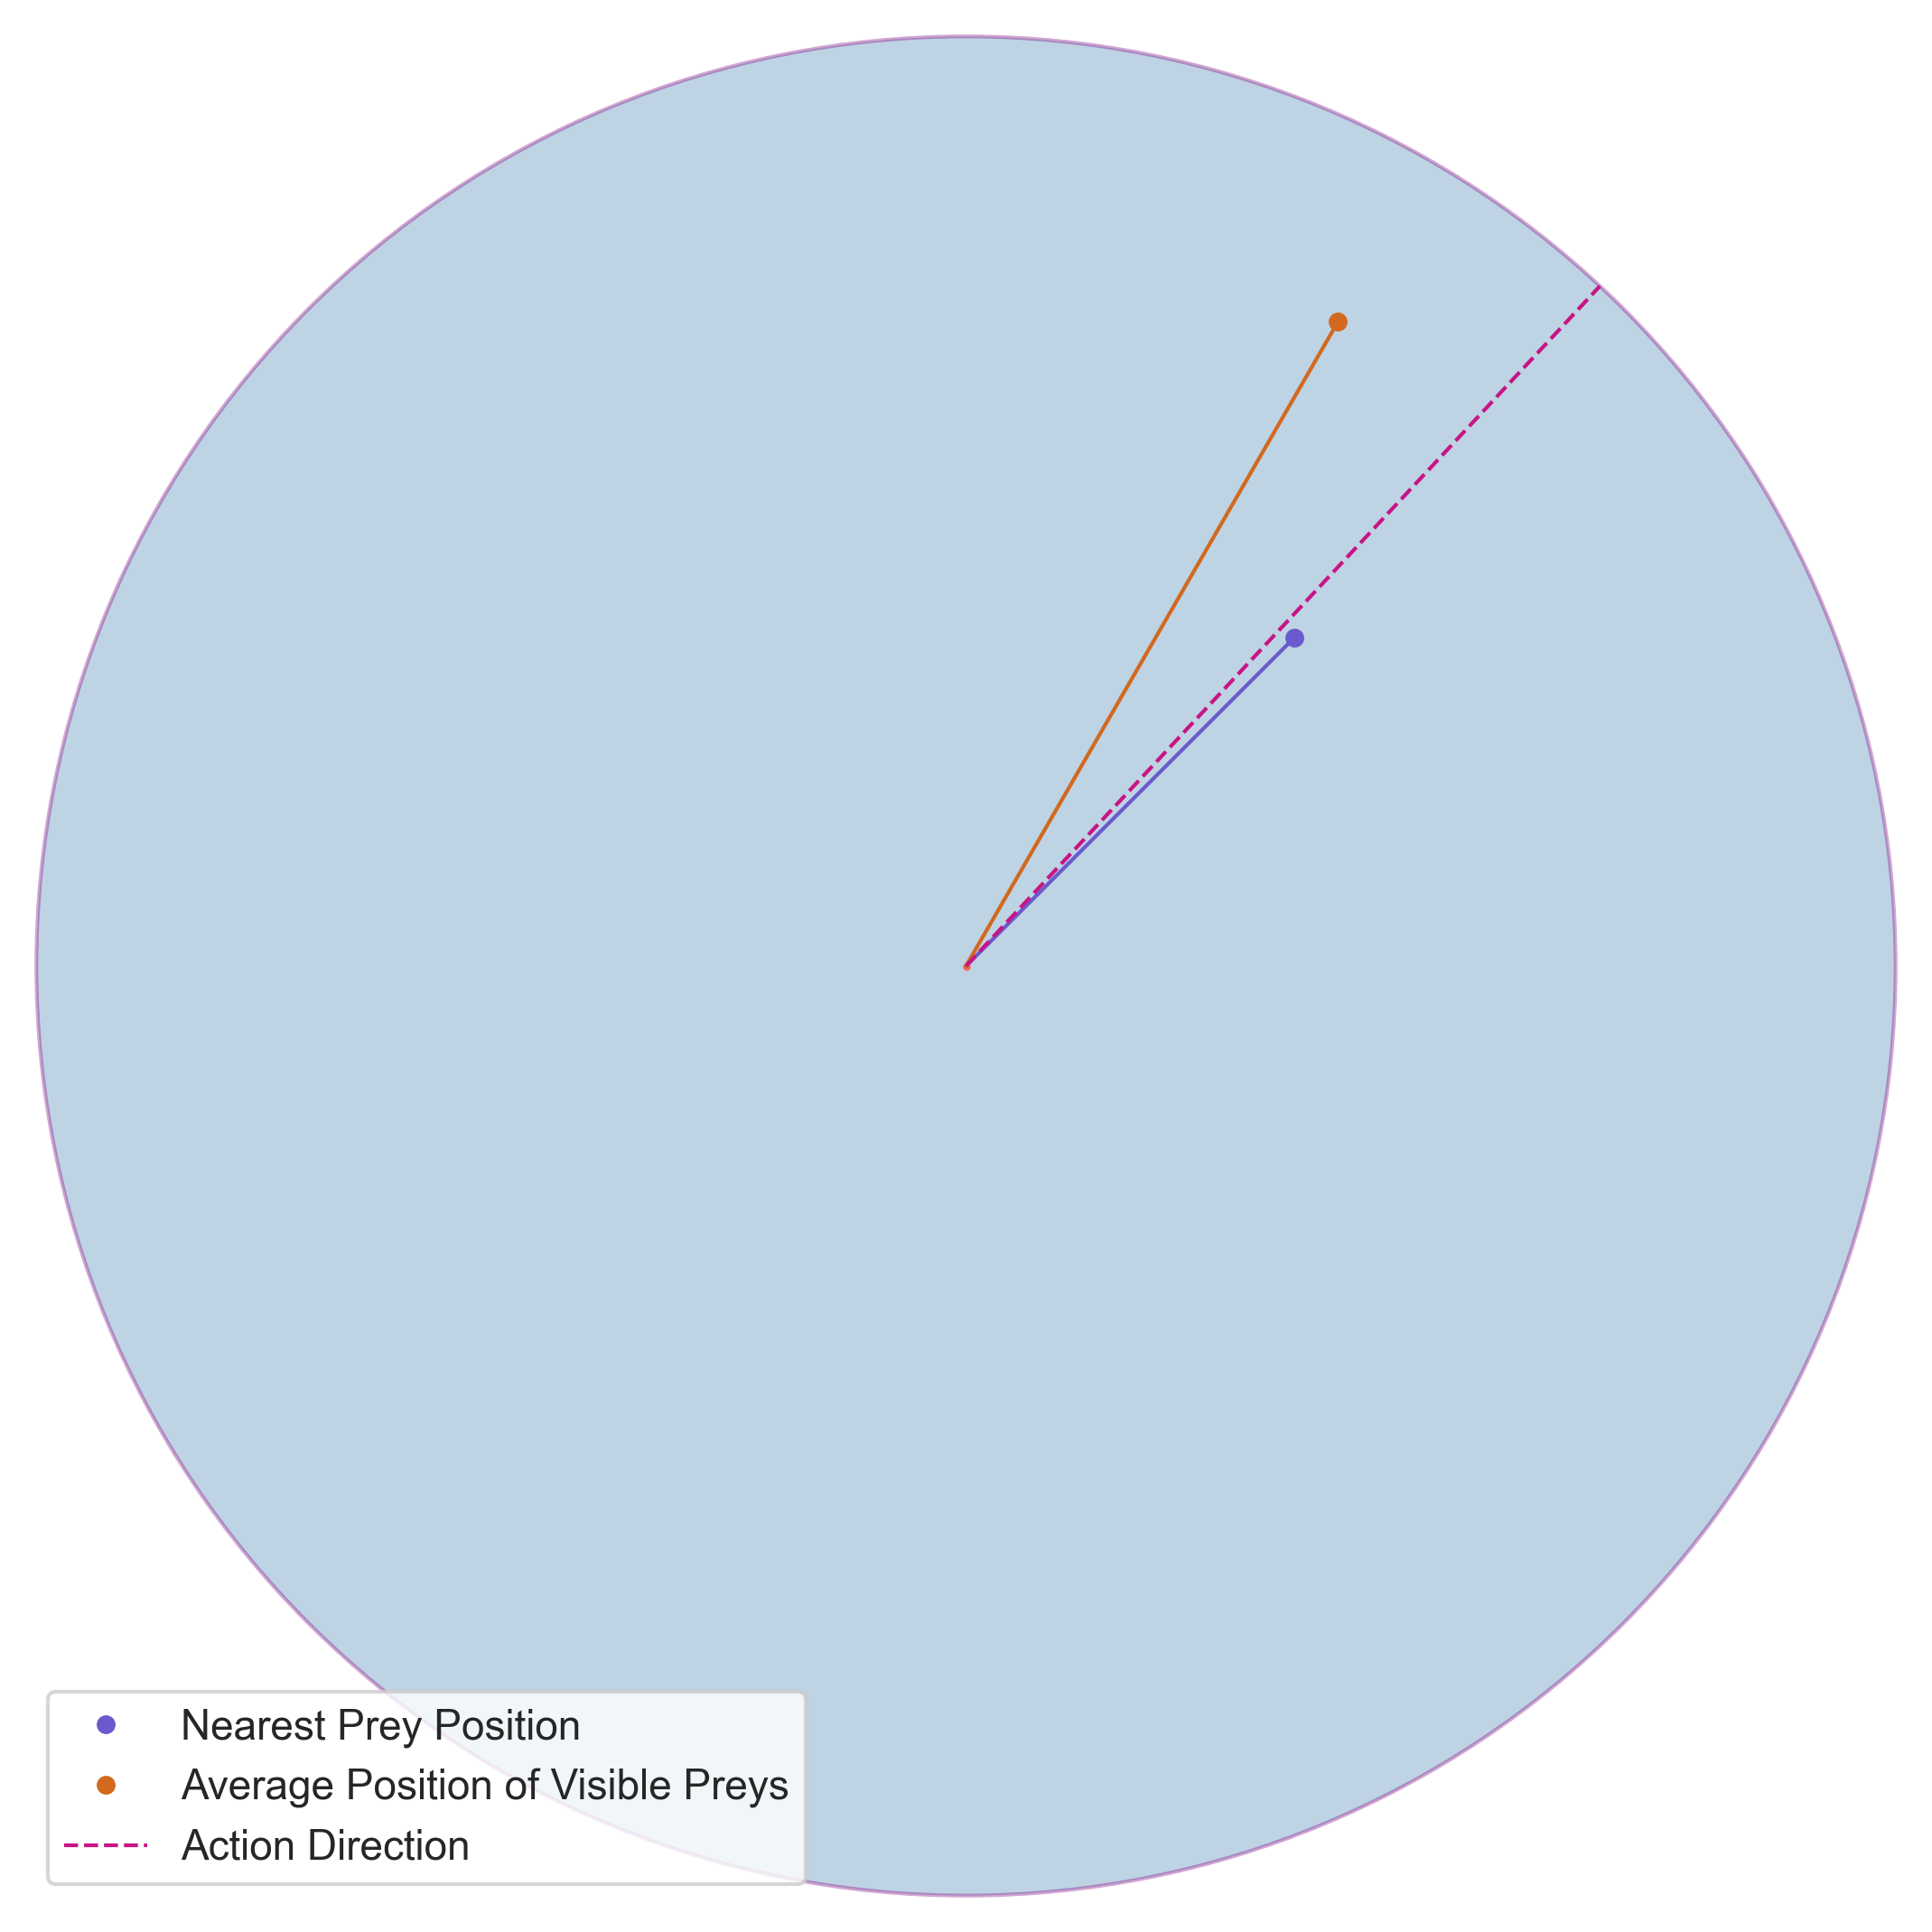

In [494]:
plot_strategy(5, np.pi/4, 8, np.pi/3, 10, predict_action=model_predict_action)

## MSD Distribution Trajectory 

In [475]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('data/trajectories_random_putback_count_2_random_5000.csv')
# 按trajectory_id分组,并统计每个轨迹结束时间中最小的time
min_max_time = df.groupby('trajectory_id')['time'].max().min()
# 打印结果
print(min_max_time)
df_clean = df[df['time'] <= min_max_time].copy()
df_clean.loc[:, 'displacement_squared'] = (df_clean['x']**2 + df_clean['y']**2)
df_clean3 = df_clean.copy()


# 读取CSV文件
df = pd.read_csv('data/trajectories_put_back_count_3_greedy_5000.csv')
# 按trajectory_id分组,并统计每个轨迹结束时间中最小的time
min_max_time = df.groupby('trajectory_id')['time'].max().min()
# 打印结果
print(min_max_time)
df_clean = df[df['time'] <= min_max_time].copy()
df_clean.loc[:, 'displacement_squared'] = (df_clean['x']**2 + df_clean['y']**2)
df_clean1 = df_clean.copy()


# 读取CSV文件
df = pd.read_csv('data/trajectories_put_back_count_3_smart_5000.csv')
# 按trajectory_id分组,并统计每个轨迹结束时间中最小的time
min_max_time = df.groupby('trajectory_id')['time'].max().min()
# 打印结果
print(min_max_time)
df_clean = df[df['time'] <= min_max_time].copy()
df_clean.loc[:, 'displacement_squared'] = (df_clean['x']**2 + df_clean['y']**2)
df_clean2 = df_clean.copy()



3404
2815
2910


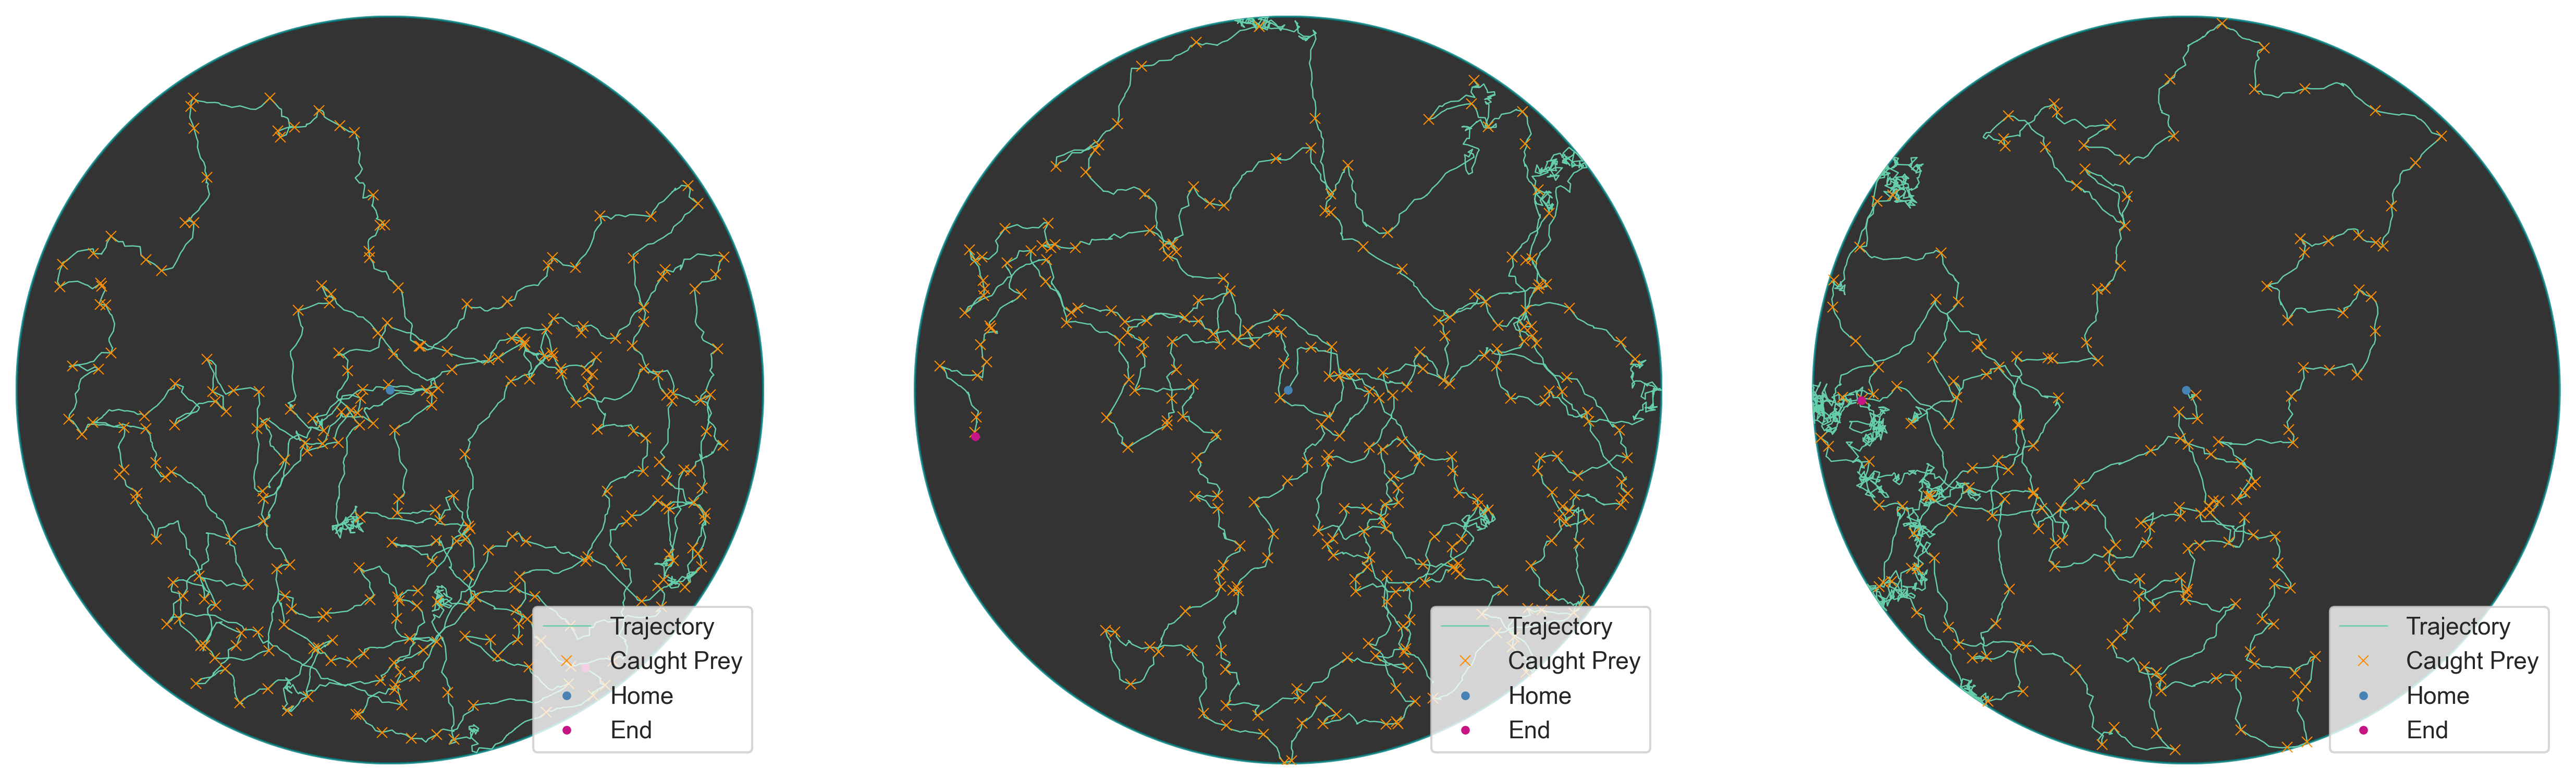

In [485]:
sample_ids = [2,5,6]
df_clean = df_clean1

fig, axs = plt.subplots(1,3, figsize=(21, 7), dpi=300)
for i, sample_id in enumerate(sample_ids):
    ax = axs[i]
    sample_traj = df_clean[df_clean['trajectory_id'] == sample_id]
    # 绘制活动范围
    arena_circle = plt.Circle((0, 0), arena_radius, facecolor='black', alpha=0.8, edgecolor='teal')
    ax.add_artist(arena_circle)
    # 绘制轨迹图
    sns.set(style="whitegrid")
    # 创建包含起点 (0,0) 的数据框
    start_point = pd.DataFrame({'x': [0], 'y': [0]})
    sample_traj_with_start = pd.concat([start_point, sample_traj], ignore_index=True) # 将起点添加到原数据框
    sns.lineplot(data=sample_traj_with_start, x='x', y='y', sort=False, ax=ax, linewidth=0.6, color='mediumaquamarine', label='Trajectory')
    # 绘制捕食成功点
    ax.plot(sample_traj[sample_traj['is_cap']]['x'], sample_traj[sample_traj['is_cap']]['y'], label='Caught Prey', marker='x', color='darkorange', linestyle='None', markersize=5, markeredgewidth=0.5)
    # 绘制家的位置和终点
    ax.plot(0, 0, marker='o', label='Home', markersize=3, color='steelblue', linestyle='None')
    ax.plot(sample_traj.iloc[-1]['x'], sample_traj.iloc[-1]['y'], marker='o', label='End', markersize=3, color='mediumvioletred', linestyle='None')
    # 设置图像样式
    ax.set_aspect('equal')
    ax.set_xlim(-arena_radius-0.1, arena_radius+0.1)
    ax.set_ylim(-arena_radius-0.1, arena_radius+0.1)
    ax.axis('off')
    ax.legend(loc='lower right')
# fig.suptitle('Smart Policy - Sample Trajectories', fontsize=25)
plt.show()

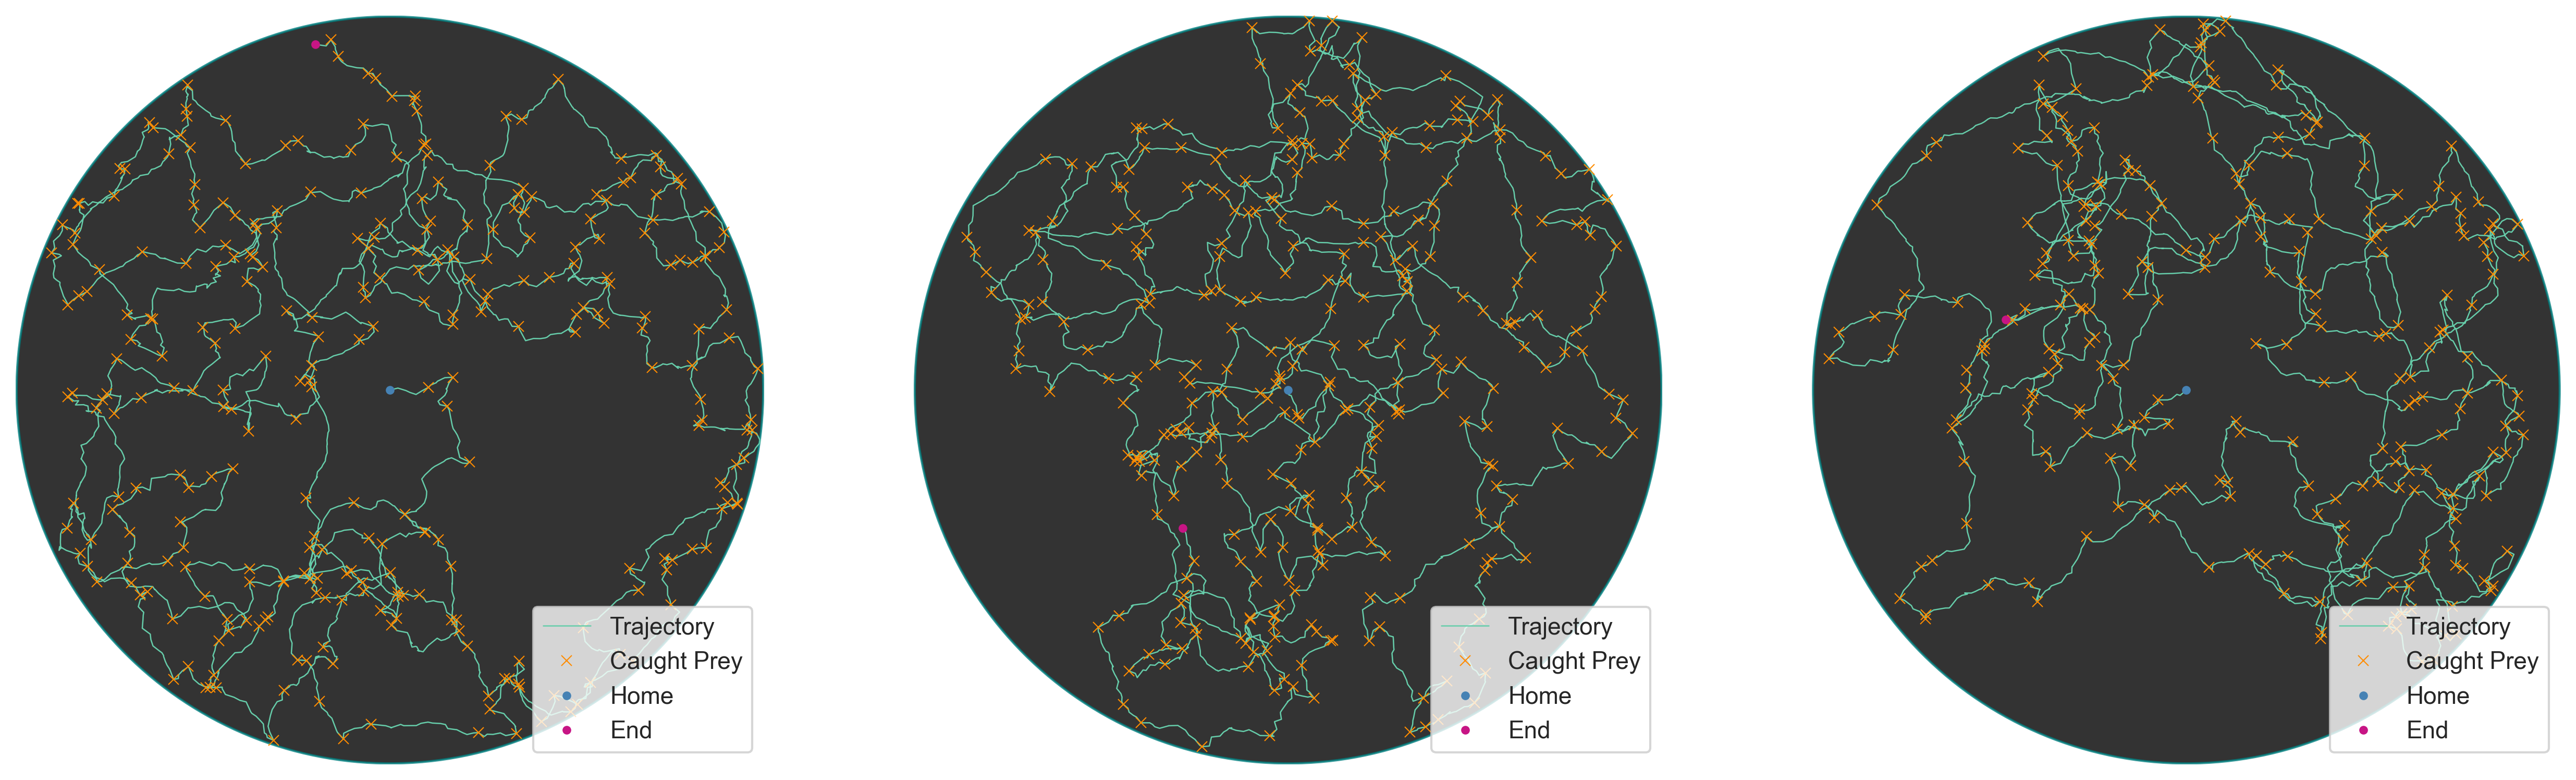

In [477]:
sample_ids = [3,4,5]
df_clean = df_clean2

fig, axs = plt.subplots(1,3, figsize=(21, 7), dpi=300)
for i, sample_id in enumerate(sample_ids):
    ax = axs[i]
    sample_traj = df_clean[df_clean['trajectory_id'] == sample_id]
    # 绘制活动范围
    arena_circle = plt.Circle((0, 0), arena_radius, facecolor='black', alpha=0.8, edgecolor='teal')
    ax.add_artist(arena_circle)
    # 绘制轨迹图
    sns.set(style="whitegrid")
    # 创建包含起点 (0,0) 的数据框
    start_point = pd.DataFrame({'x': [0], 'y': [0]})
    sample_traj_with_start = pd.concat([start_point, sample_traj], ignore_index=True) # 将起点添加到原数据框
    sns.lineplot(data=sample_traj_with_start, x='x', y='y', sort=False, ax=ax, linewidth=0.6, color='mediumaquamarine', label='Trajectory')
    # 绘制捕食成功点
    ax.plot(sample_traj[sample_traj['is_cap']]['x'], sample_traj[sample_traj['is_cap']]['y'], label='Caught Prey', marker='x', color='darkorange', linestyle='None', markersize=5, markeredgewidth=0.5)
    # 绘制家的位置和终点
    ax.plot(0, 0, marker='o', label='Home', markersize=3, color='steelblue', linestyle='None')
    ax.plot(sample_traj.iloc[-1]['x'], sample_traj.iloc[-1]['y'], marker='o', label='End', markersize=3, color='mediumvioletred', linestyle='None')
    # 设置图像样式
    ax.set_aspect('equal')
    ax.set_xlim(-arena_radius-0.1, arena_radius+0.1)
    ax.set_ylim(-arena_radius-0.1, arena_radius+0.1)
    ax.axis('off')
    ax.legend(loc='lower right')
# fig.suptitle('Smart Policy - Sample Trajectories', fontsize=25)
plt.show()

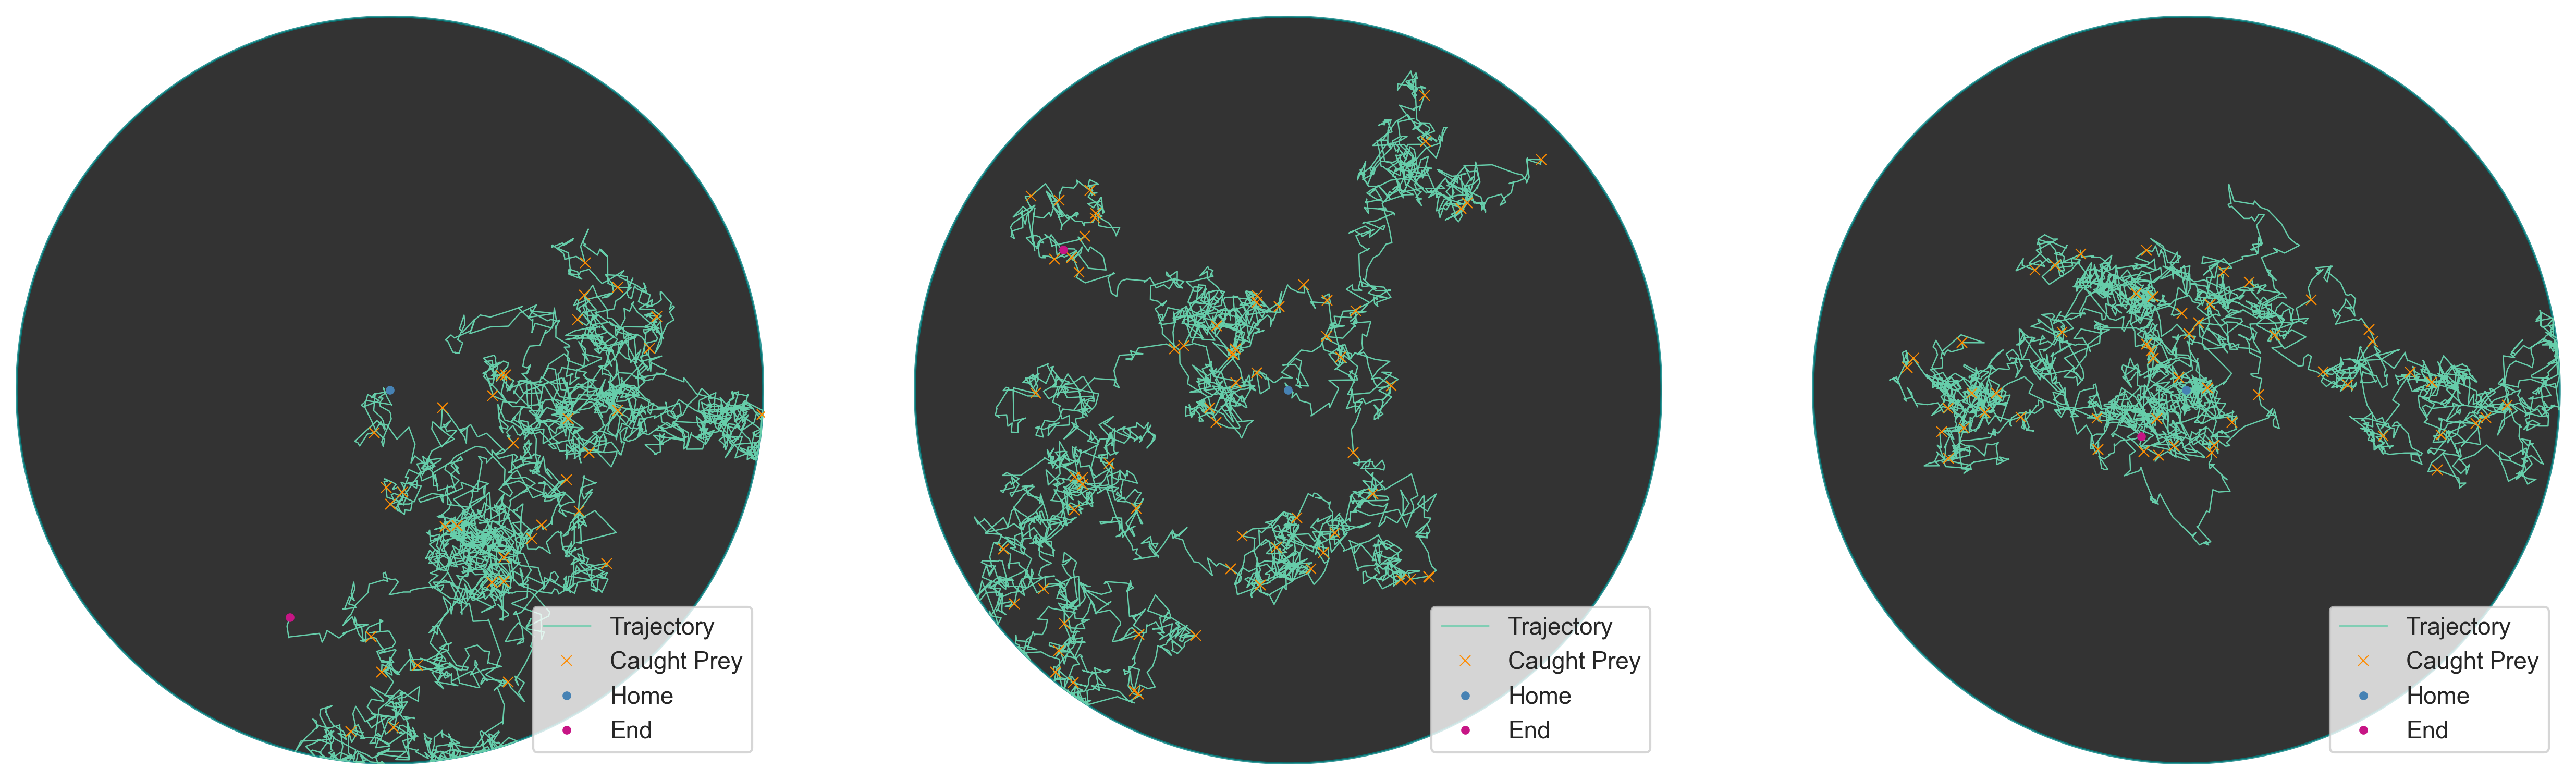

In [486]:
sample_ids = [3,4,5]
df_clean = df_clean3

fig, axs = plt.subplots(1,3, figsize=(21, 7), dpi=300)
for i, sample_id in enumerate(sample_ids):
    ax = axs[i]
    sample_traj = df_clean[df_clean['trajectory_id'] == sample_id]
    # 绘制活动范围
    arena_circle = plt.Circle((0, 0), arena_radius, facecolor='black', alpha=0.8, edgecolor='teal')
    ax.add_artist(arena_circle)
    # 绘制轨迹图
    sns.set(style="whitegrid")
    # 创建包含起点 (0,0) 的数据框
    start_point = pd.DataFrame({'x': [0], 'y': [0]})
    sample_traj_with_start = pd.concat([start_point, sample_traj], ignore_index=True) # 将起点添加到原数据框
    sns.lineplot(data=sample_traj_with_start, x='x', y='y', sort=False, ax=ax, linewidth=0.6, color='mediumaquamarine', label='Trajectory')
    # 绘制捕食成功点
    ax.plot(sample_traj[sample_traj['is_cap']]['x'], sample_traj[sample_traj['is_cap']]['y'], label='Caught Prey', marker='x', color='darkorange', linestyle='None', markersize=5, markeredgewidth=0.5)
    # 绘制家的位置和终点
    ax.plot(0, 0, marker='o', label='Home', markersize=3, color='steelblue', linestyle='None')
    ax.plot(sample_traj.iloc[-1]['x'], sample_traj.iloc[-1]['y'], marker='o', label='End', markersize=3, color='mediumvioletred', linestyle='None')
    # 设置图像样式
    ax.set_aspect('equal')
    ax.set_xlim(-arena_radius-0.1, arena_radius+0.1)
    ax.set_ylim(-arena_radius-0.1, arena_radius+0.1)
    ax.axis('off')
    ax.legend(loc='lower right')
# fig.suptitle('Smart Policy - Sample Trajectories', fontsize=25)
plt.show()

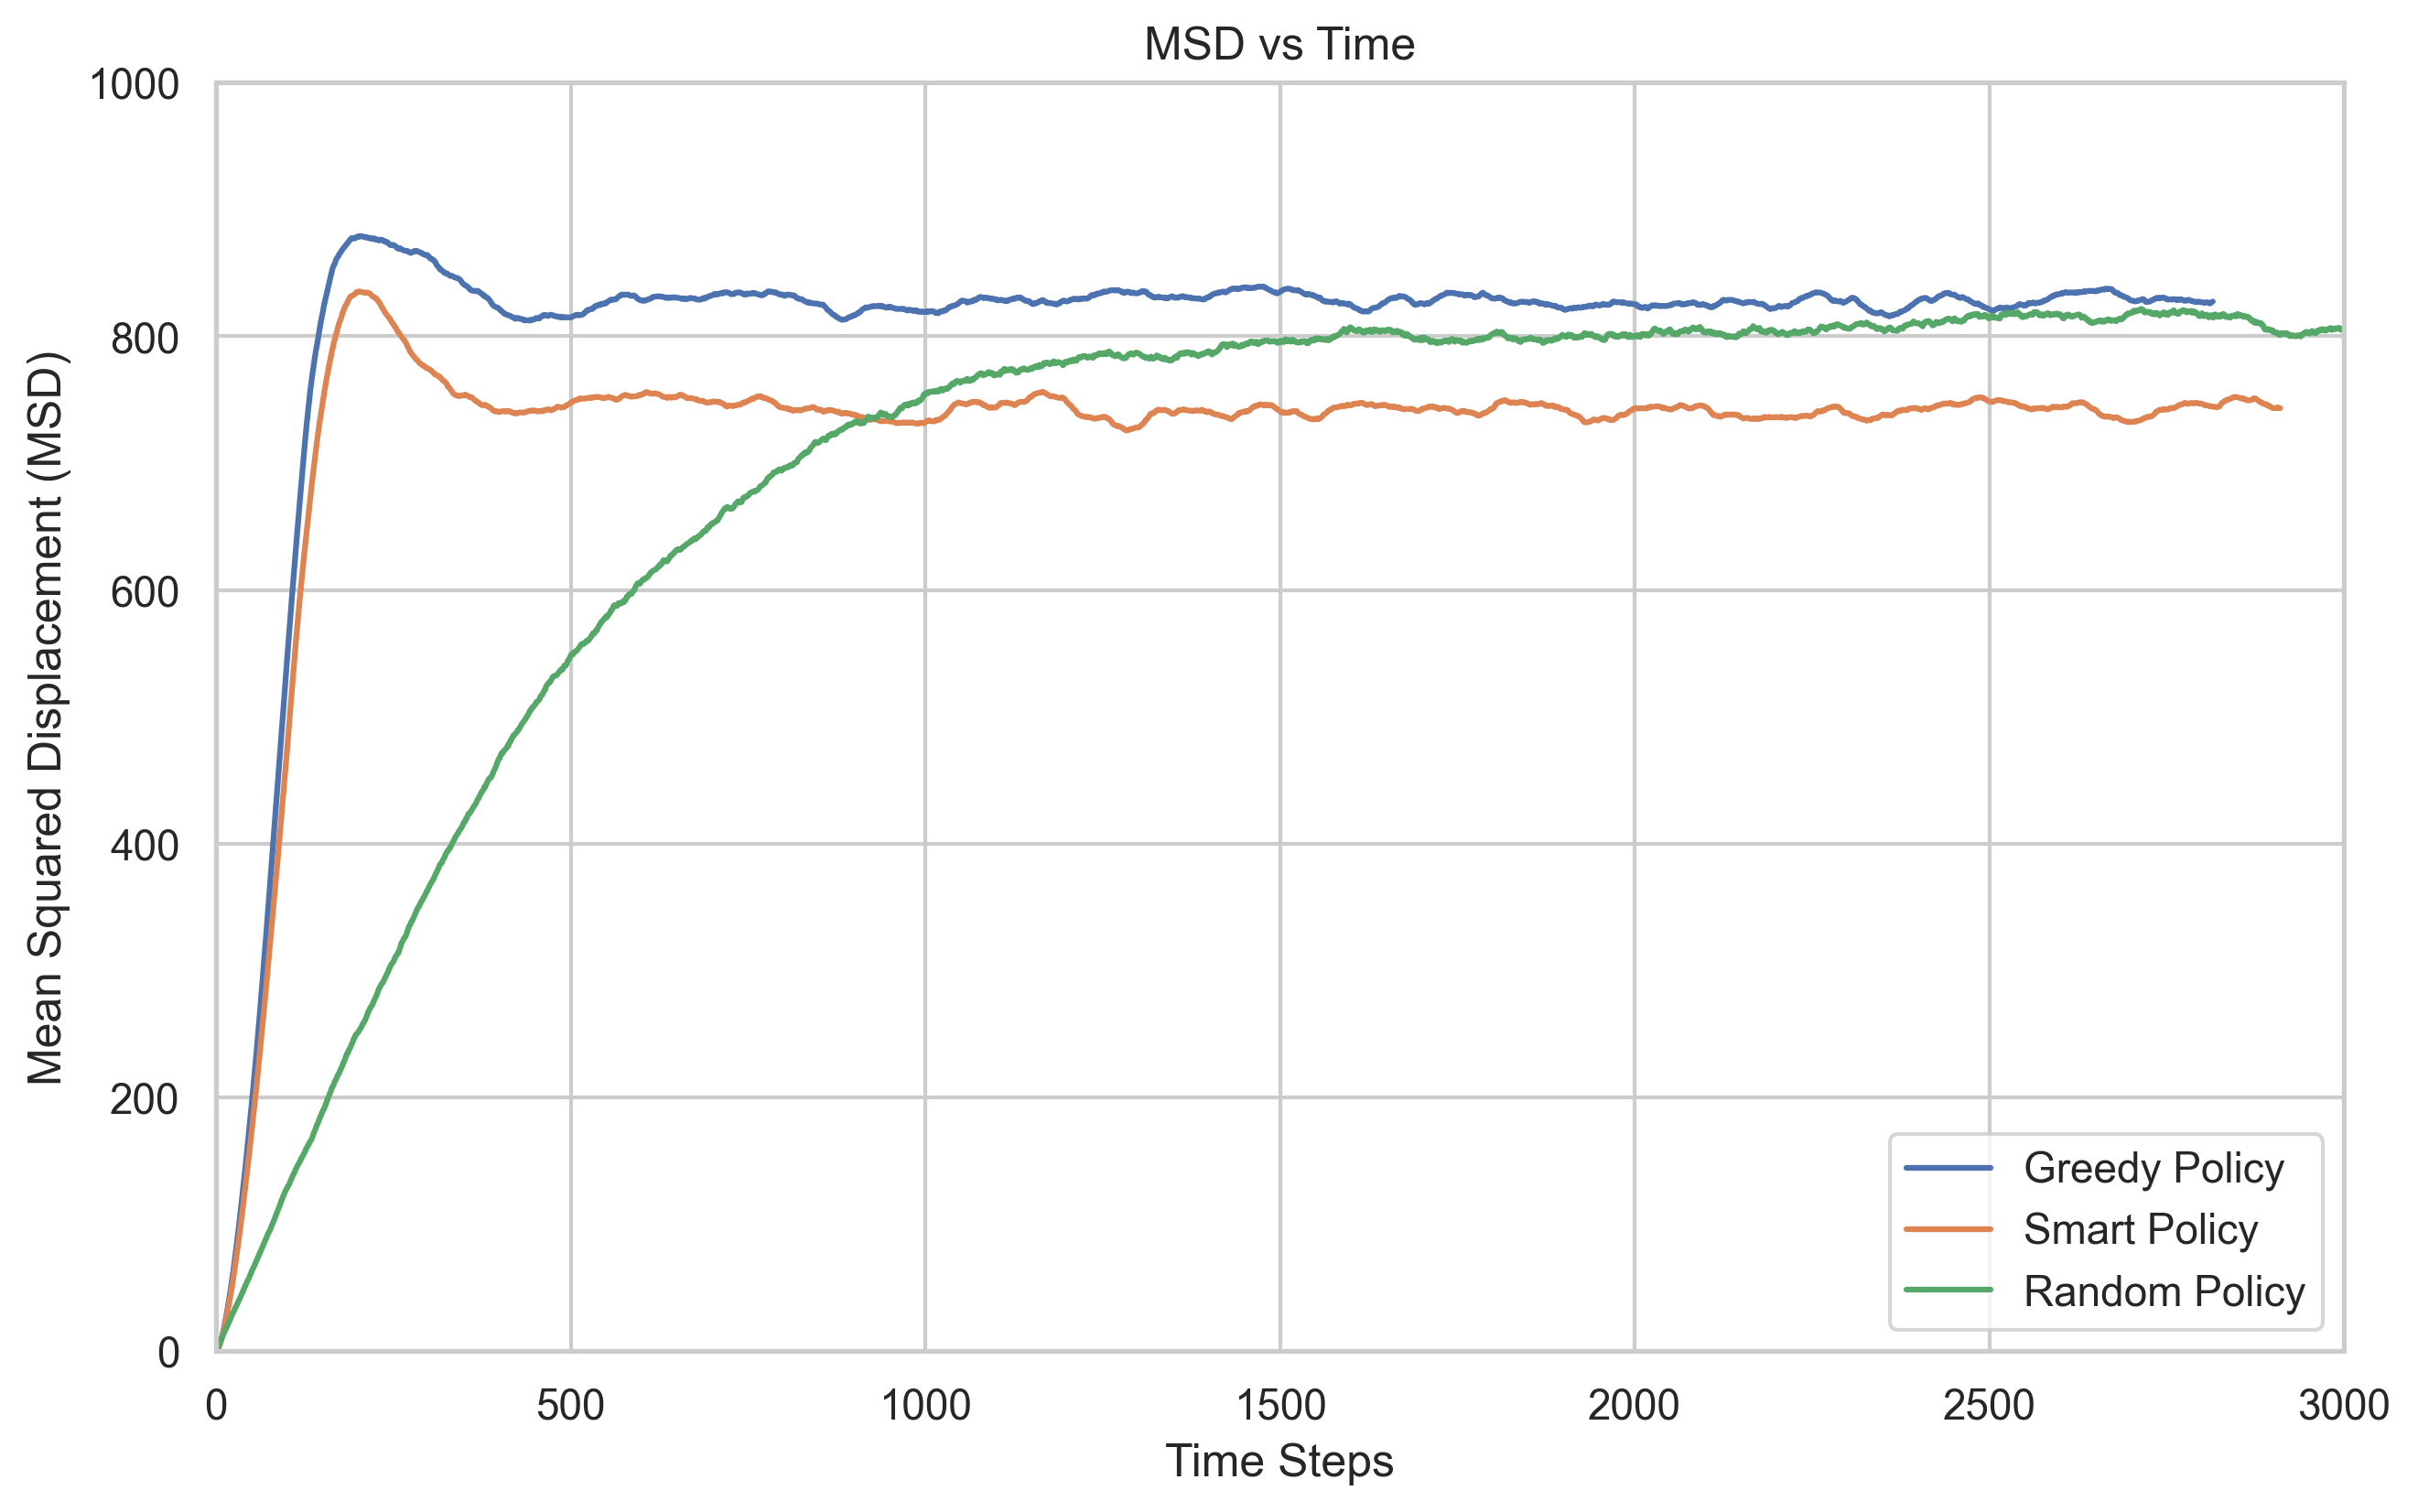

In [479]:
import seaborn as sns
import matplotlib.pyplot as plt
# 按时间分组并计算平均平方位移
msd1 = df_clean1.groupby('time')['displacement_squared'].mean().reset_index()
msd2 = df_clean2.groupby('time')['displacement_squared'].mean().reset_index()
msd3 = df_clean3.groupby('time')['displacement_squared'].mean().reset_index()

# 使用Seaborn绘制图表
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6), dpi = 300)
sns.lineplot(data=msd1, x='time', y='displacement_squared', label='Greedy Policy')
sns.lineplot(data=msd2, x='time', y='displacement_squared', label='Smart Policy')
sns.lineplot(data=msd3, x='time', y='displacement_squared', label='Random Policy')
plt.xlabel('Time Steps')
plt.ylabel('Mean Squared Displacement (MSD)')
plt.title('MSD vs Time')
plt.xlim(0, 3000)
plt.ylim(0, 1000)
plt.legend(loc = 'lower right')
plt.show()

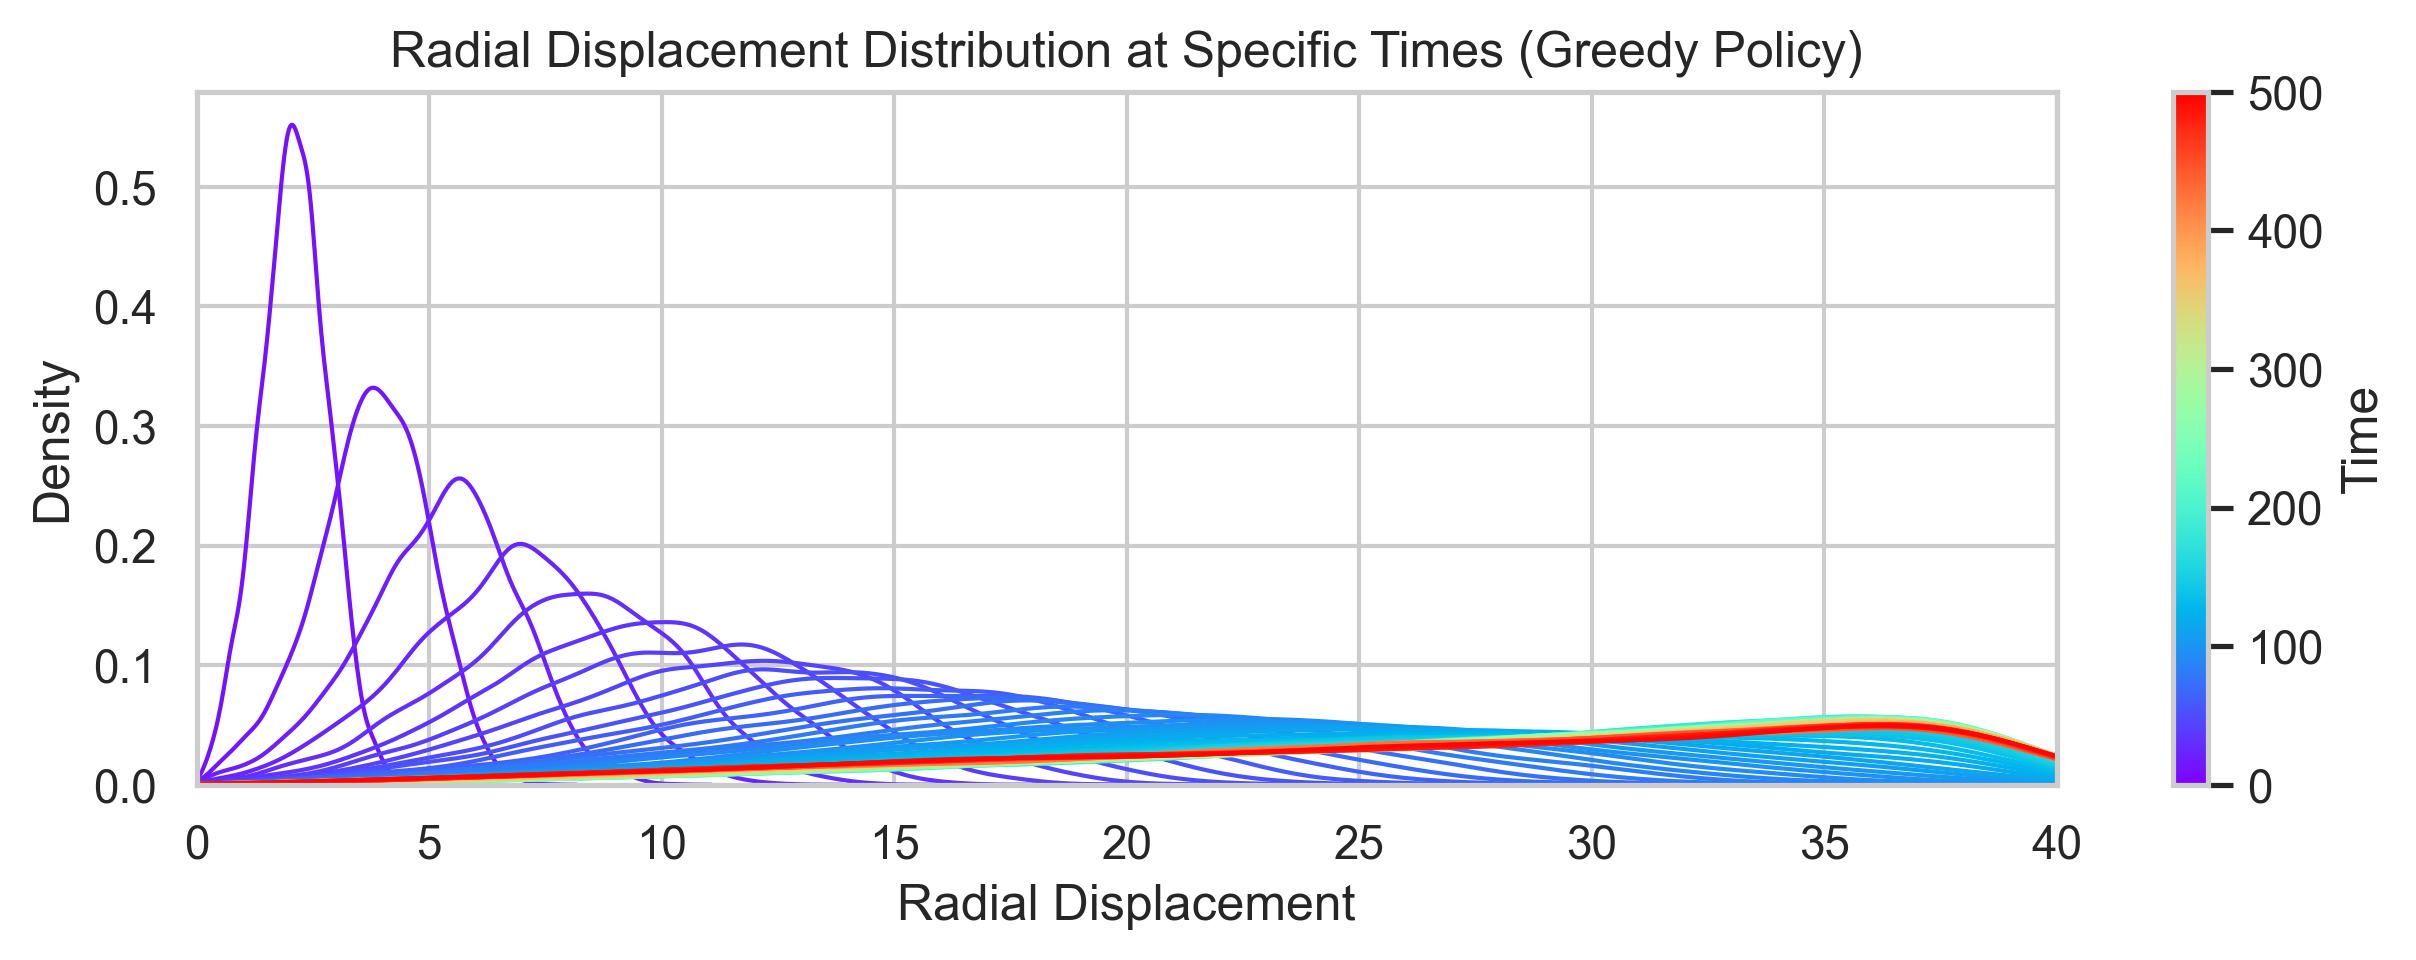

In [481]:
# 选几个t List 对同一个t 中每个id由x y计算r 统计r的分布,绘制图像
times = range(0, 501, 5)
fig, ax = plt.subplots(figsize=(10, 3), dpi = 300)

df_clean = df_clean1
df_clean.loc[:, 'r'] = (df_clean['x']**2 + df_clean['y']**2)**0.5
filtered_data = df_clean[df_clean['time'].isin(times)]
# 绘制径向位移分布图
sns.set(style="whitegrid")
# 使用 Seaborn 的调色盘,例如 'coolwarm' 或 'viridis'
palette = sns.color_palette('rainbow', len(times))
for i, time_point in enumerate(times):
    subset = filtered_data[filtered_data['time'] == time_point]
    sns.kdeplot(subset['r'], color=palette[i], bw_adjust=1.0, linewidth=1.0)
    
# 创建 colorbar
norm = plt.Normalize(vmin=min(times), vmax=max(times))
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
sm.set_array([])  # 这是必须的

# 添加 colorbar 到图中
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Time')    
plt.xlabel('Radial Displacement')
plt.ylabel('Density')
plt.xlim(0, 40)
plt.title('Radial Displacement Distribution at Specific Times (Greedy Policy)')
plt.show()

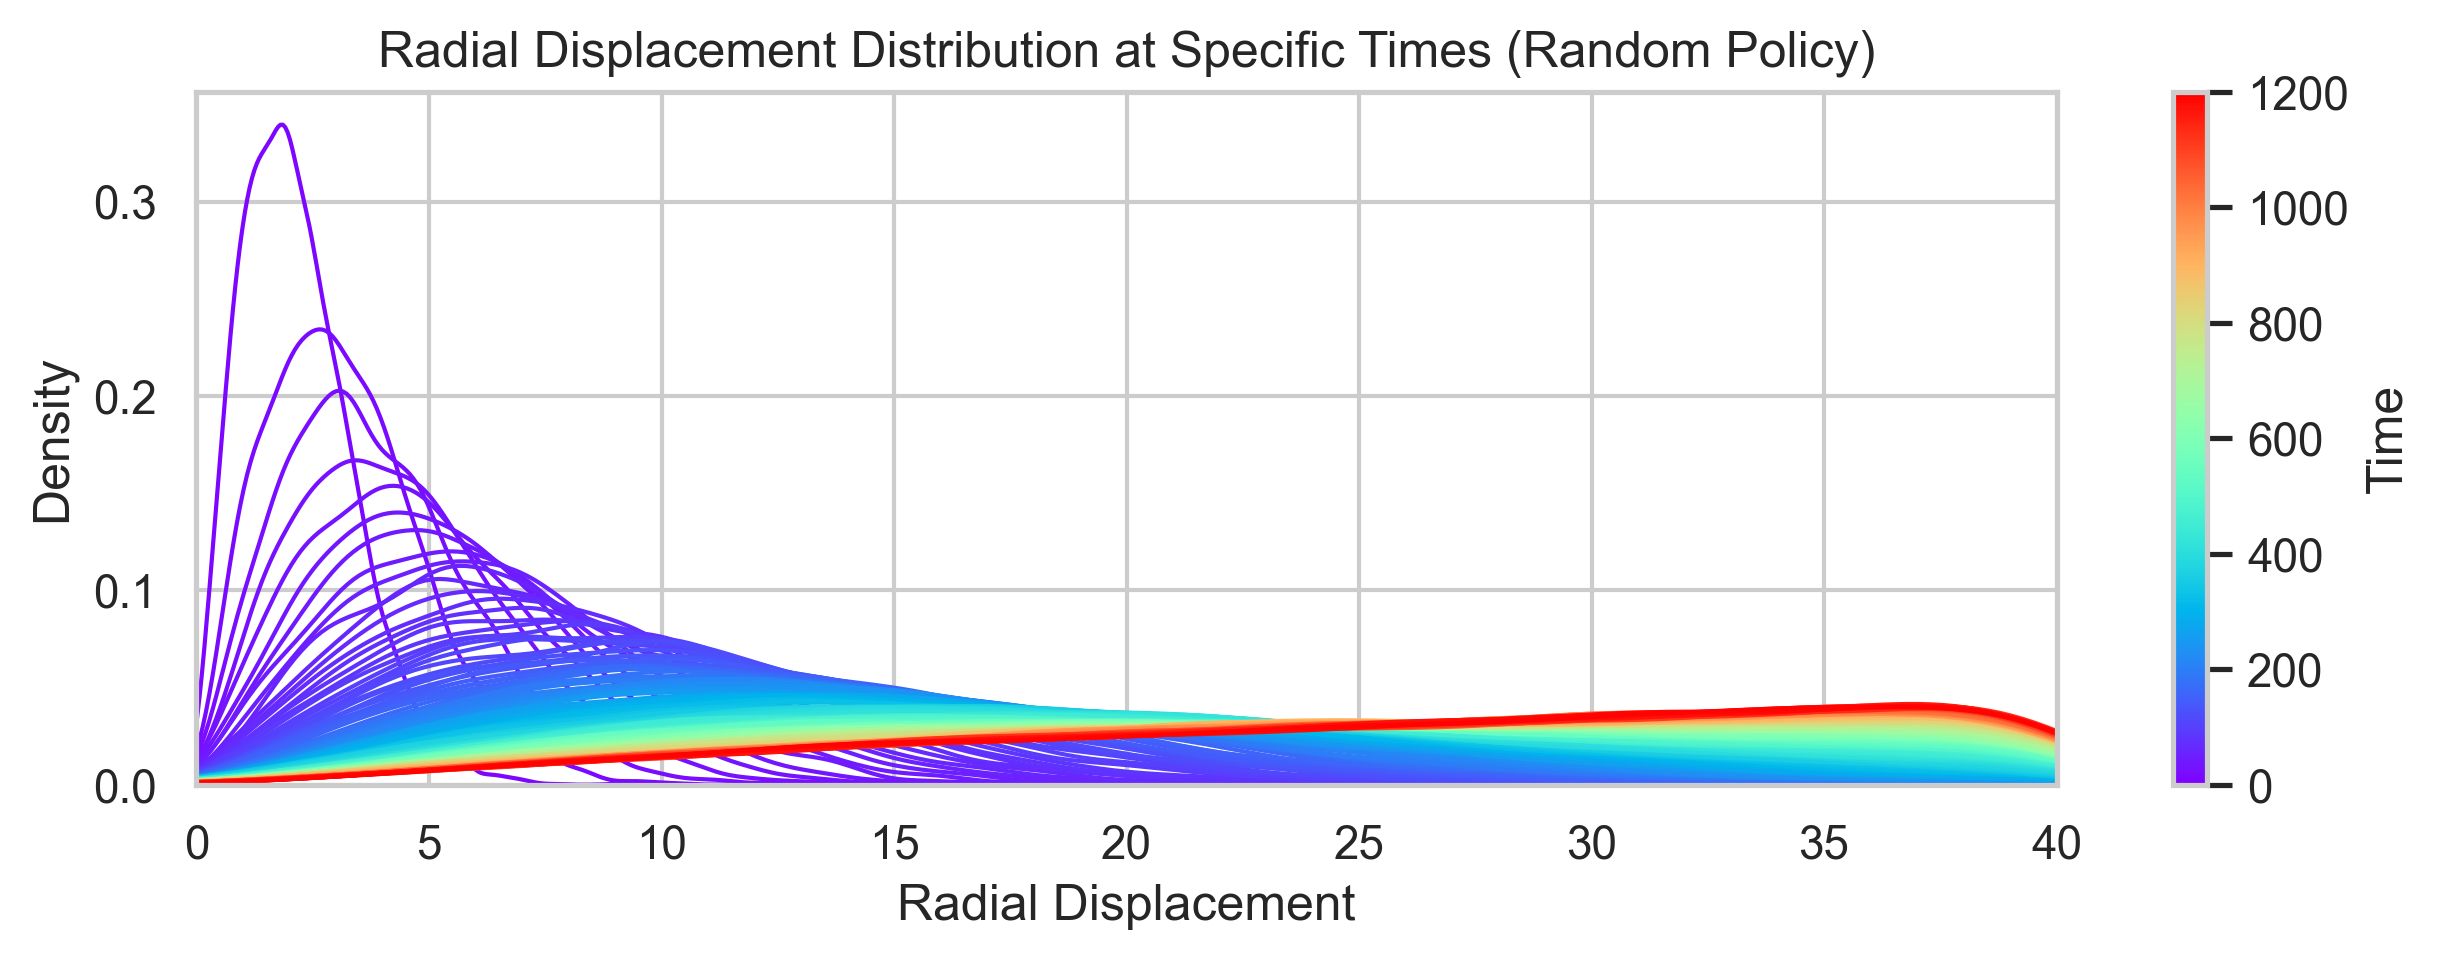

In [483]:
# 选几个t List 对同一个t 中每个id由x y计算r 统计r的分布,绘制图像
times = range(0, 1201, 5)
fig, ax = plt.subplots(figsize=(10, 3), dpi = 300)

df_clean = df_clean3
df_clean.loc[:, 'r'] = (df_clean['x']**2 + df_clean['y']**2)**0.5
filtered_data = df_clean[df_clean['time'].isin(times)]
# 绘制径向位移分布图
sns.set(style="whitegrid")
# 使用 Seaborn 的调色盘,例如 'coolwarm' 或 'viridis'
palette = sns.color_palette('rainbow', len(times))
for i, time_point in enumerate(times):
    subset = filtered_data[filtered_data['time'] == time_point]
    sns.kdeplot(subset['r'], color=palette[i], bw_adjust=1.0, linewidth=1.0)
    
# 创建 colorbar
norm = plt.Normalize(vmin=min(times), vmax=max(times))
sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
sm.set_array([])  # 这是必须的

# 添加 colorbar 到图中
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Time')    
plt.xlabel('Radial Displacement')
plt.ylabel('Density')
plt.xlim(0, 40)
plt.title('Radial Displacement Distribution at Specific Times (Random Policy)')
plt.show()

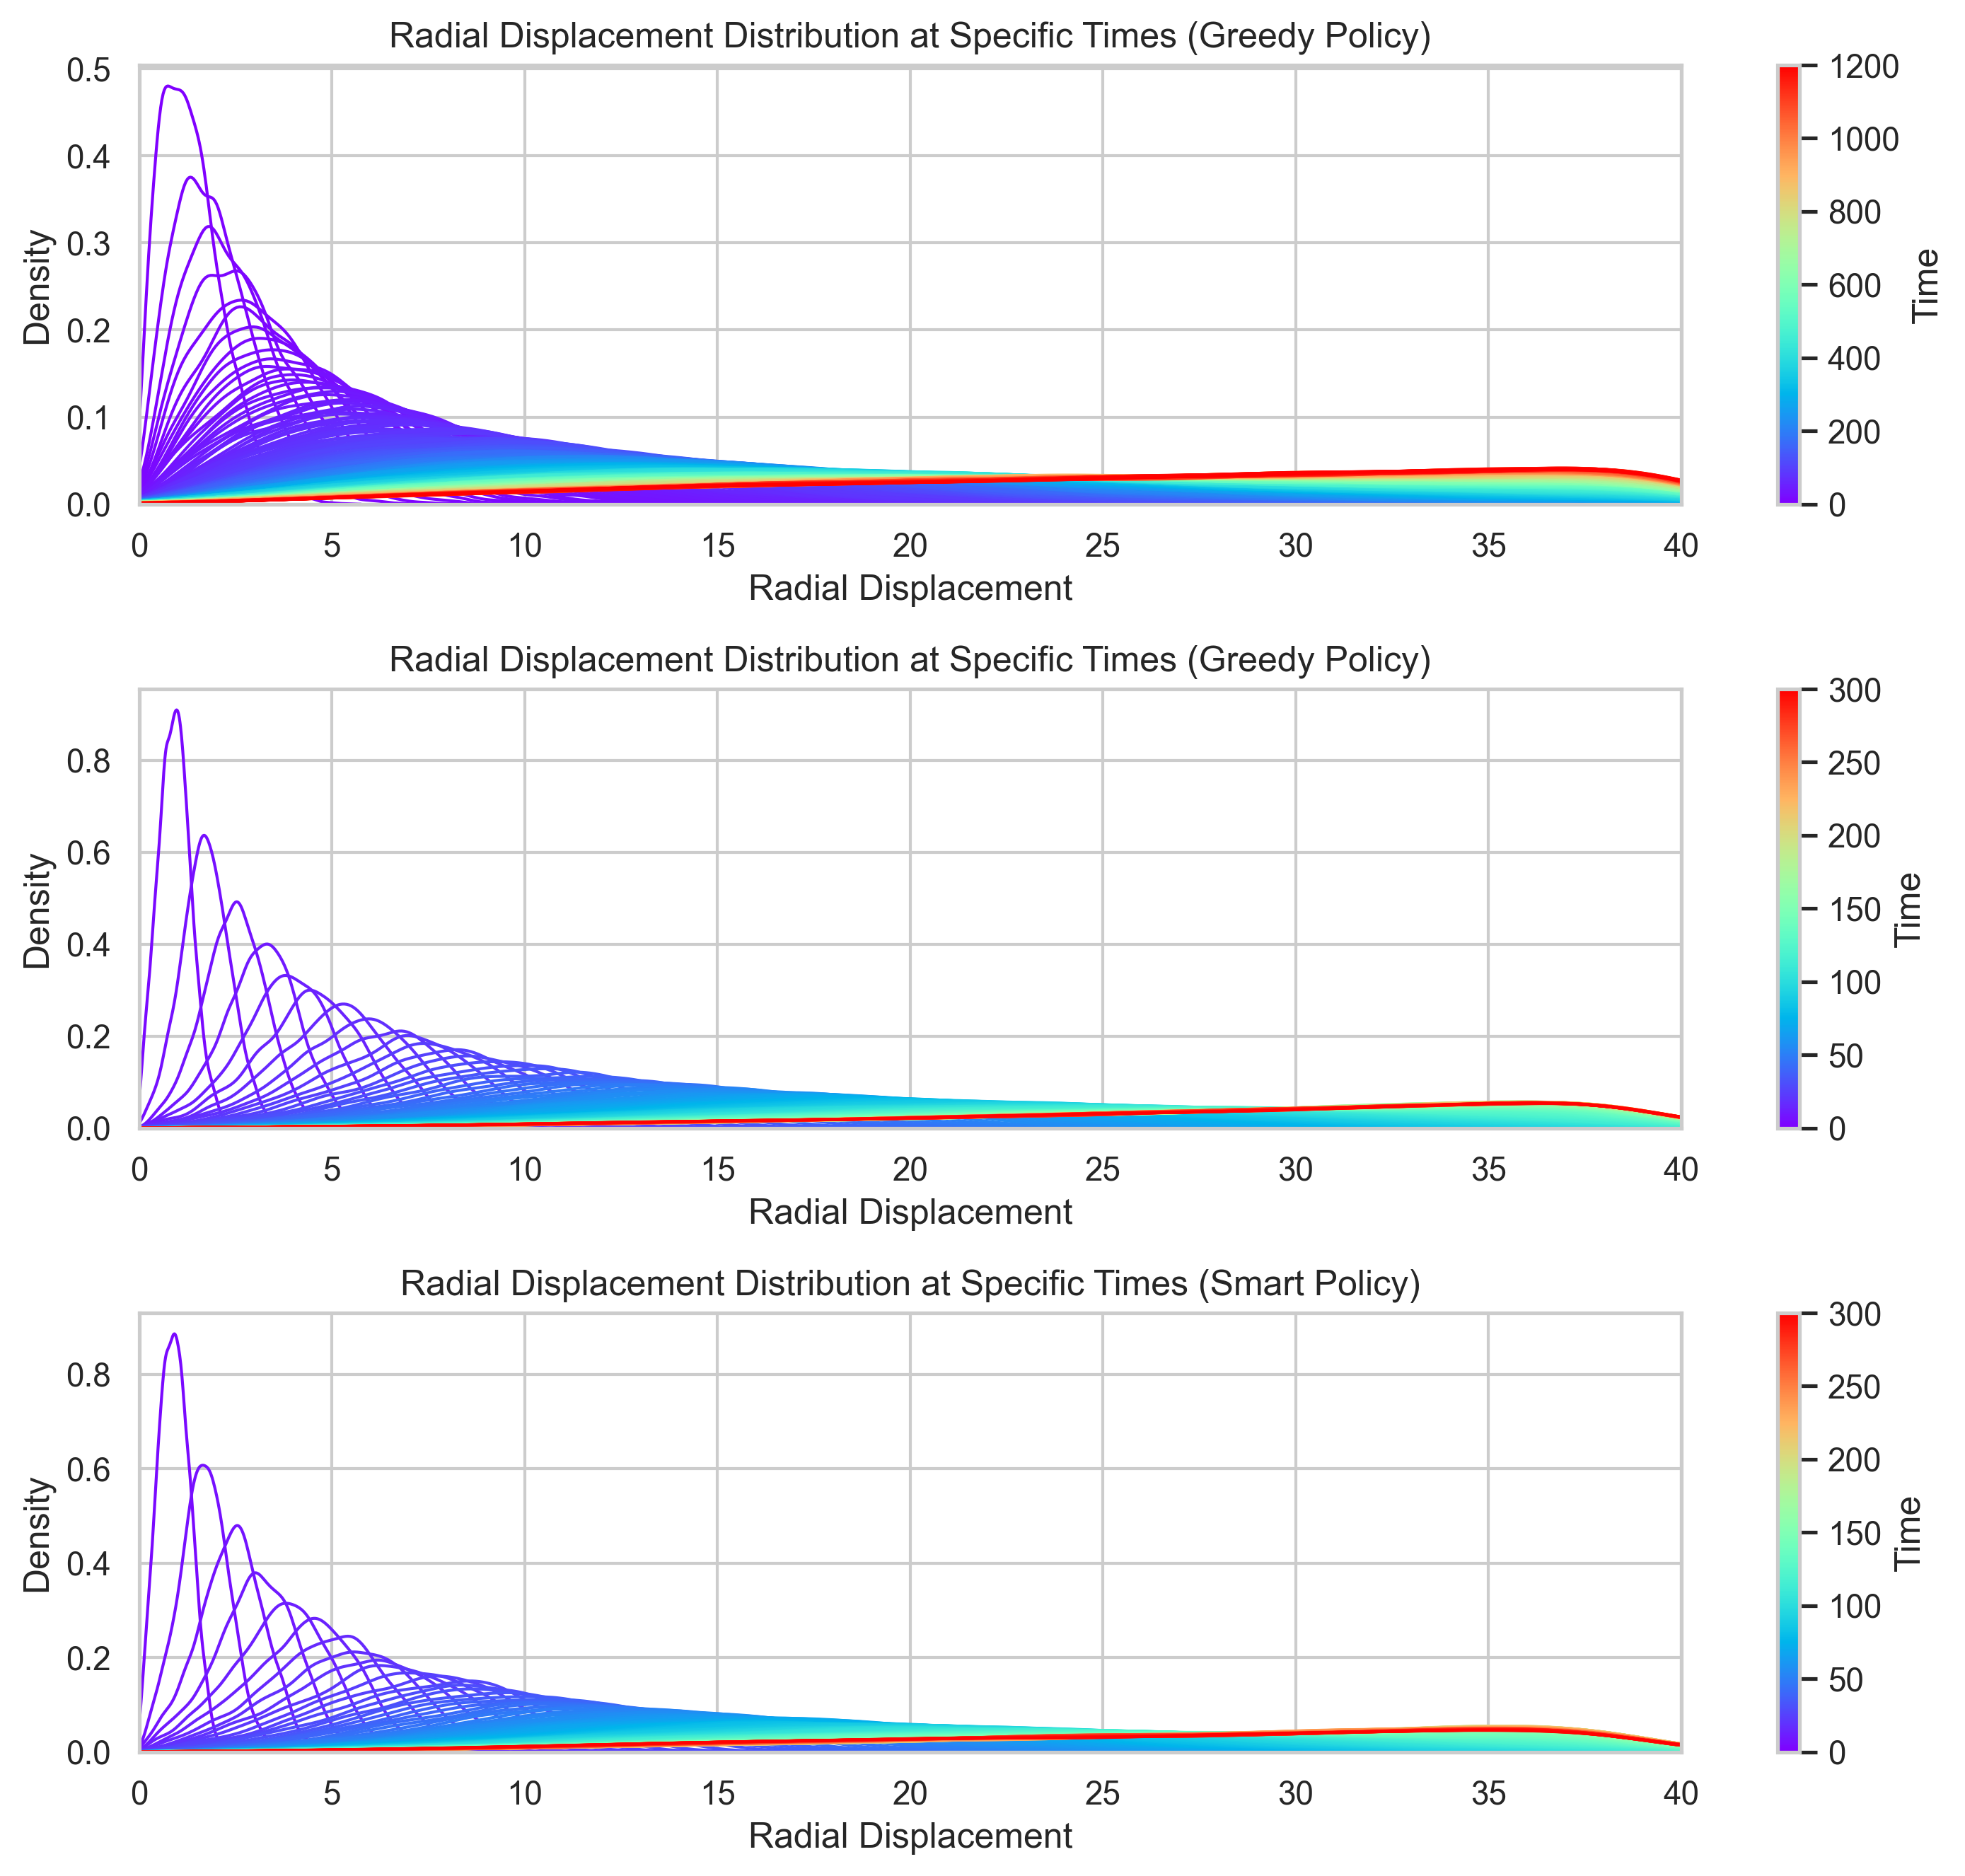

In [491]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_radial_displacement(ax, df, times, title):
    df.loc[:, 'r'] = (df['x']**2 + df['y']**2)**0.5
    filtered_data = df[df['time'].isin(times)]
    
    sns.set(style="whitegrid")
    palette = sns.color_palette('rainbow', len(times))
    
    for i, time_point in enumerate(times):
        subset = filtered_data[filtered_data['time'] == time_point]
        sns.kdeplot(subset['r'], color=palette[i], bw_adjust=1.0, linewidth=1.0, ax=ax)
        
    norm = plt.Normalize(vmin=min(times), vmax=max(times))
    sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Time')
    
    ax.set_xlabel('Radial Displacement')
    ax.set_ylabel('Density')
    ax.set_xlim(0, 40)
    ax.set_title(title)

fig, axs = plt.subplots(3, 1, figsize=(10, 9), dpi=300)

times = range(0, 301, 2)
times3 = range(0, 1201, 2)

# 绘制第一个子图
plot_radial_displacement(axs[0], df_clean3, times3, 'Radial Displacement Distribution at Specific Times (Greedy Policy)')

# 绘制第二个子图
plot_radial_displacement(axs[1], df_clean1, times, 'Radial Displacement Distribution at Specific Times (Greedy Policy)')

# 绘制第三个子图
plot_radial_displacement(axs[2], df_clean2, times, 'Radial Displacement Distribution at Specific Times (Smart Policy)')

plt.tight_layout()
plt.show()